### IS727272 - Cordero Hernández, Marco Ricardo

# Actividad de práctica de Regresión Logística

## Parte 0: Funciones requeridas

In [1]:
# Normalizador 
def normalize(x):
    x_norm = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
    return x_norm

# 1's
def Bias(X):
    ones = np.ones((len(X), 1))
    X1 = np.concatenate((ones, X), axis = 1)
    return X1

# Función logística 
def h(x, w):
    wx = np.dot(x, w.T)
    z = 1 / (1 + np.exp(-wx))
    return z

# Función de costo
def cost(x, y, w):
    m, n = np.shape(x)
    c = (-1 / m)*np.sum(y * np.log(h(x, w)) + (1 - y) * np.log((1 - h(x, w))))
    return c

# Gradiente
def grad(x, y, w):
    m, n = np.shape(x)
    g = (1 / m) * np.dot(x.T,(h(x, w)-y))
    return g

# Gradiente descendiente
def gd(x, y, w, alpha = 0.001, its = 1000):
    it = 0
    costo = 0
    J = {}
    while it < its:
        # Gradient
        gradiente = grad(x, y, w)
            
        # Cost function
        costo = cost(x, y, w)
            
        # Updating w
        w = w - alpha * gradiente.T
                
        # Storing cost
        J[it] = costo
   
        it += 1
              
    return w, J

# Precisión
def accuracy(x, y, w):
    
    Ynew = list(map(lambda x: 1 if x >= 0.5 else 0, h(x, w)))
               
    Ynew = np.array(Ynew)
    Ynew = Ynew.reshape(-1,1)
    suma = (y == Ynew).sum()
    
    a = suma/len(y)
    
    return a, suma

# Predicción
def predict(p, threshold):
    return list(map(lambda x: 1 if x >= threshold else 0, p))

# Valores para matriz
def values(y, pred):
    tp = tn = fn = fp = 0
    
    for i in range(len(y)):
        tp += 1 if (y[i] and pred[i]) else 0
        fp += 1 if (not y[i] and pred[i]) else 0
        tn += 1 if (not y[i] and not pred[i]) else 0
        fn += 1 if (y[i] and not pred[i]) else 0
    
    V = {'TP': tp, 'TN': tn, 'FN': fn, 'FP': fp}
    return V

# TPR
def tpr(V):
    return V['TP'] / (V['TP'] + V['FN'])

# FPR
def fpr(V):    
    return V['FP'] / (V['FP'] + V['TN'])

# Curva ROC
def ROC(y, p):
    thrs = np.arange(0, 1, 0.005)
    TPR = np.zeros(len(thrs))
    FPR = np.zeros(len(thrs))
    
    for i in range(len(thrs)):
        pred = predict(p, thrs[i])
        TPR[i] = tpr(values(y, pred))
        FPR[i] = fpr(values(y, pred))
    
    return TPR, FPR

# Matriz de confusión
def plot_confusion_matrix(values, classes):
    import itertools
    m, n = values.shape

    accuracy = np.trace(values) / float(np.sum(values))
    misclass = 1 - accuracy

    plt.figure(figsize=(5, 5))
    plt.imshow(values, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion matrix')
    plt.colorbar()

    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation=45)
    plt.yticks(marks, classes)

    thresh = values.max() / 2
    for i, j in itertools.product(range(m), range(n)):
        plt.text(j, i, "{:,}".format(values[i, j]),
                 horizontalalignment="center",
                 color="white" if values[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [2]:
# Librerías y módulos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## Parte 1: Water potability

In [3]:
# Lectura del dataset
df_wp = pd.read_csv('./Datasets/water_potability.csv')
df_wp.head()

data_wp = np.array(df_wp)
row, col = np.shape(data_wp)
print(f'Rows: {row}; Cols: {col}')

# Checar nulos
df_wp.isna().sum(axis = 0)

Rows: 3276; Cols: 10


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [4]:
# Se encontraron nulos en ph, Sulfate y Trihalomethanes; se deben rellenar
def fill_null(ds, col):
    ds[col].fillna(value = int(ds[col].mean()), inplace = True)

    
fill_null(df_wp, 'ph')
fill_null(df_wp, 'Sulfate')
fill_null(df_wp, 'Trihalomethanes')


# Verificación
df_wp.isna().sum(axis = 0)

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [5]:
# Dado el contexto del dataset, se ha determinado que Potability será la salida (Y)
data_wp = np.array(df_wp)

x_wp = data_wp[:, : -1]
y_wp = data_wp[:, -1]
y_wp = y_wp.reshape(-1, 1)

print(f'X: {np.shape(x_wp)}\nY: {np.shape(y_wp)}')

X: (3276, 9)
Y: (3276, 1)


In [6]:
# Normalizar x
X_wp_norm = normalize(x_wp)
print(np.shape(X_wp_norm))

(3276, 9)


In [7]:
# Preparar y bifurcar datos
x_wp = Bias(X_wp_norm)
print(np.shape(x_wp))

test_size = 0.33
xTrain_wp, xTest_wp, yTrain_wp, yTest_wp = train_test_split(x_wp, y_wp,test_size = test_size)
print('Split X', len(x_wp), 'rows into train with', len(xTrain_wp), 'and test with', len(xTest_wp))
print('Split Y', len(y_wp), 'rows into train with', len(yTrain_wp), 'and test with', len(yTest_wp))

yTrain_wp = yTrain_wp.reshape(-1,1)
yTest_wp = yTest_wp.reshape(-1,1)

print('xTrain shape:',np.shape(xTrain_wp), 'yTrain shape:', np.shape(yTrain_wp))
print('xTest shape:', np.shape(xTest_wp), 'yTest shape:', np.shape(yTest_wp))

(3276, 10)
Split X 3276 rows into train with 2194 and test with 1082
Split Y 3276 rows into train with 2194 and test with 1082
xTrain shape: (2194, 10) yTrain shape: (2194, 1)
xTest shape: (1082, 10) yTest shape: (1082, 1)


Initial Cost (training data): 0.6931471805599453
Cost after training (training data): 0.6670208212506439
Cost after training (testing data): 0.6685205486488206
W: [[-0.41008623  0.0065311  -0.03035836  0.05531924  0.04490138 -0.03435561
  -0.04652737 -0.04689643  0.01183504  0.01126765]]


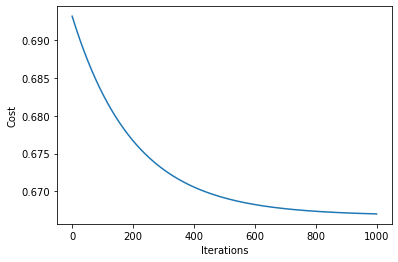

In [8]:
# Gradiente descendiente
alpha = 0.01
its = 1000

m, n = np.shape(x_wp)
w = np.zeros((1, n))

print('Initial Cost (training data):', cost(xTrain_wp, yTrain_wp, w))

# Gradient
w, J = gd(xTrain_wp, yTrain_wp, w, alpha, its)

print('Cost after training (training data):', cost(xTrain_wp, yTrain_wp, w))
print('Cost after training (testing data):', cost(xTest_wp, yTest_wp, w))

print('W:',w)

# Plot the cost over the iterations
plt.plot(J.keys(), J.values())
plt.xlabel('Iterations')
plt.ylabel('Cost');

In [9]:
# Precisión
accTrain_wp, tptnTrain_wp = accuracy(xTrain_wp, yTrain_wp, w)
accTest_wp, tptnTest_wp = accuracy(xTest_wp, yTest_wp, w)
print('Training accuracy:', accTrain_wp, tptnTrain_wp, 'out of', len(yTrain_wp))
print('Testing accuracy:', accTest_wp, tptnTest_wp, 'out of', len(yTest_wp))

Training accuracy: 0.6103008204193254 1339 out of 2194
Testing accuracy: 0.6090573012939002 659 out of 1082


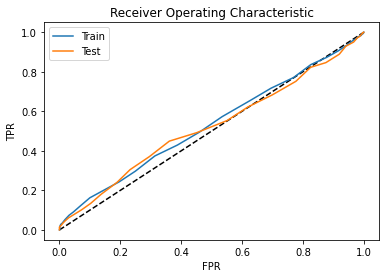

In [10]:
# ROC
# Entrenamiento
Tpr_wp, Fpr_wp = ROC(yTrain_wp, h(xTrain_wp, w))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(Fpr_wp, Tpr_wp, '-', label = "Train")

# Test
Tpr1_wp, Fpr1_wp = ROC(yTest_wp, h(xTest_wp, w))
plt.plot(Fpr1_wp, Tpr1_wp, '-', label = "Test")

plt.xlabel('FPR')
plt.ylabel('TPR');
plt.legend()
plt.title('Receiver Operating Characteristic');

In [11]:
# AUC
rectangle_roc_wp = 0
rectangle_roc1_wp = 0

for i in range(len(Tpr_wp) - 1):
    rectangle_roc_wp += (Fpr_wp[i] - Fpr_wp[i + 1]) * Tpr_wp[i]
else:
    print('AUC Training: ', rectangle_roc_wp)

for i in range(len(Tpr_wp) - 1):
    rectangle_roc1_wp += (Fpr1_wp[i] - Fpr1_wp[i + 1]) * Tpr1_wp[i]
else:
    print('AUC Testing: ', rectangle_roc1_wp)

AUC Training:  0.5567723141560647
AUC Testing:  0.5476526150015961


[[1339    0]
 [ 855    0]]


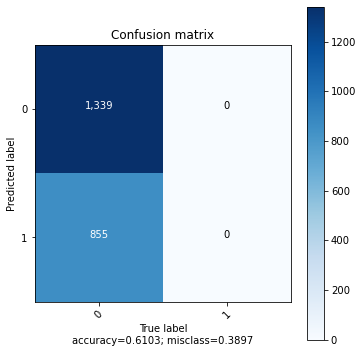

In [12]:
# Matriz de confusión
pred_wp = predict(h(xTrain_wp, w), 0.5)
cm_wp = confusion_matrix(yTrain_wp, pred_wp)
print(cm_wp)

plot_confusion_matrix(values = cm_wp, classes = ['0', '1'])

In [13]:
# Implementación desde SKLEARN
LR_wp = LogisticRegression(solver='lbfgs')
LR_wp.fit(xTrain_wp, yTrain_wp)
LR_wp_score = LR_wp.score(xTest_wp, yTest_wp)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# Comparación
print(f'Puntuación: {accTest_wp}\t\tPuntuación sklearn: {LR_wp_score}')

Puntuación: 0.6090573012939002		Puntuación sklearn: 0.6090573012939002


## Parte 2: Spambase

In [15]:
# Lectura del dataset
df_sp = pd.read_csv('./Datasets/spambase.data', header = None)
df_sp.head()

data_sp = np.array(df_sp)
row, col = np.shape(data_sp)
print(f'Rows: {row}; Cols: {col}')

# Checar nulos
df_sp.isna().sum(axis = 0)

Rows: 4601; Cols: 58


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
dtype: int64

In [16]:
# Dada la información del dataset, se entiende que la última columna es el resultado
data_sp = np.array(df_wp)

x_sp = data_sp[:, : -1]
y_sp = data_sp[:, -1]
y_sp = y_sp.reshape(-1, 1)

print(f'X: {np.shape(x_sp)}\nY: {np.shape(y_sp)}')

X: (3276, 9)
Y: (3276, 1)


In [17]:
# Normalizar x
X_sp_norm = normalize(x_sp)
print(np.shape(X_sp_norm))

(3276, 9)


In [18]:
# Preparar y bifurcar datos
x_sp = Bias(X_sp_norm)
print(np.shape(x_sp))

xTrain_sp, xTest_sp, yTrain_sp, yTest_sp = train_test_split(x_sp, y_sp,test_size = test_size)
print('Split X', len(x_sp), 'rows into train with', len(xTrain_sp), 'and test with', len(xTest_sp))
print('Split Y', len(y_sp), 'rows into train with', len(yTrain_sp), 'and test with', len(yTest_sp))

yTrain_sp = yTrain_sp.reshape(-1,1)
yTest_sp = yTest_sp.reshape(-1,1)

print('xTrain shape:',np.shape(xTrain_sp), 'yTrain shape:', np.shape(yTrain_sp))
print('xTest shape:', np.shape(xTest_sp), 'yTest shape:', np.shape(yTest_sp))

(3276, 10)
Split X 3276 rows into train with 2194 and test with 1082
Split Y 3276 rows into train with 2194 and test with 1082
xTrain shape: (2194, 10) yTrain shape: (2194, 1)
xTest shape: (1082, 10) yTest shape: (1082, 1)


Initial Cost (training data): 0.6931471805599453
Cost after training (training data): 0.6677998282516671
Cost after training (testing data): 0.6687795233469315
W: [[-0.39771043 -0.0483199  -0.04518195  0.0548357   0.02775887 -0.02023465
  -0.00897108 -0.07298211  0.03886435 -0.01453563]]


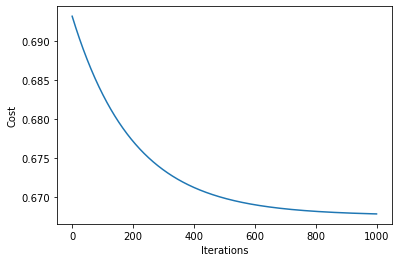

In [19]:
# Gradiente descendiente
alpha = 0.01
its = 1000

m, n = np.shape(x_sp)
w = np.zeros((1, n))

print('Initial Cost (training data):', cost(xTrain_sp, yTrain_sp, w))

# Gradient
w, J = gd(xTrain_sp, yTrain_sp, w, alpha, its)

print('Cost after training (training data):', cost(xTrain_sp, yTrain_sp, w))
print('Cost after training (testing data):', cost(xTest_sp, yTest_sp, w))

print('W:',w)

# Plot the cost over the iterations
plt.plot(J.keys(), J.values())
plt.xlabel('Iterations')
plt.ylabel('Cost');

In [20]:
# Precisión
accTrain_sp, tptnTrain_sp = accuracy(xTrain_sp, yTrain_sp, w)
accTest_sp, tptnTest_sp = accuracy(xTest_sp, yTest_sp, w)
print('Training accuracy:', accTrain_sp, tptnTrain_sp, 'out of', len(yTrain_sp))
print('Testing accuracy:', accTest_sp, tptnTest_sp, 'out of', len(yTest_sp))

Training accuracy: 0.6061987237921604 1330 out of 2194
Testing accuracy: 0.6118299445471349 662 out of 1082


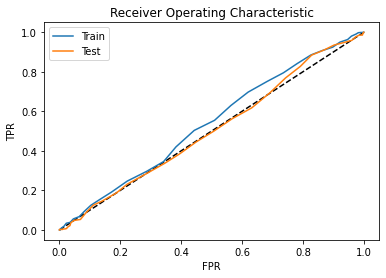

In [21]:
# ROC
# Entrenamiento
Tpr_sp, Fpr_sp = ROC(yTrain_sp, h(xTrain_sp, w))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(Fpr_sp, Tpr_sp, '-', label = "Train")

# Test
Tpr1_sp, Fpr1_sp = ROC(yTest_sp, h(xTest_sp, w))
plt.plot(Fpr1_sp, Tpr1_sp, '-', label = "Test")

plt.xlabel('FPR')
plt.ylabel('TPR');
plt.legend()
plt.title('Receiver Operating Characteristic');

In [22]:
# AUC
rectangle_roc_sp = 0
rectangle_roc1_sp = 0

for i in range(len(Tpr_sp) - 1):
    rectangle_roc_sp += (Fpr_sp[i] - Fpr_sp[i + 1]) * Tpr_sp[i]
else:
    print('AUC Training: ', rectangle_roc_sp)

for i in range(len(Tpr_sp) - 1):
    rectangle_roc1_sp += (Fpr1_sp[i] - Fpr1_sp[i + 1]) * Tpr1_sp[i]
else:
    print('AUC Testing: ', rectangle_roc1_sp)

AUC Training:  0.5599642565999876
AUC Testing:  0.5278571841071842


[[1330    2]
 [ 862    0]]


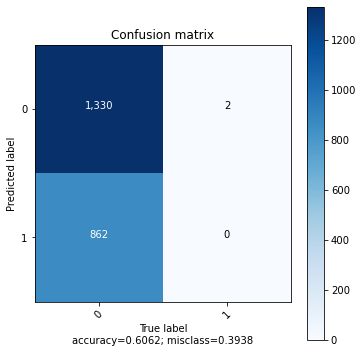

In [23]:
# Matriz de confusión
pred_sp = predict(h(xTrain_sp, w), 0.5)
cm_sp = confusion_matrix(yTrain_sp, pred_sp)
print(cm_sp)

plot_confusion_matrix(values = cm_sp, classes = ['0', '1'])

In [24]:
# Implementación desde SKLEARN
LR_sp = LogisticRegression(solver='lbfgs')
LR_sp.fit(xTrain_sp, yTrain_sp)
LR_sp_score = LR_sp.score(xTest_sp, yTest_sp)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
# Comparación
print(f'Puntuación: {accTest_sp}\t\tPuntuación sklearn: {LR_sp_score}')

Puntuación: 0.6118299445471349		Puntuación sklearn: 0.6118299445471349


¿Por qué el modelo de un dataset tiene mejor desempeño que el otro?
Los datos del segundo dataset están construidos de una mejor manera